In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def fermi(E, T=0):
    """Fermi distribution function."""
    if T==0:
        return np.heaviside(-E, 0.5)
    else:
        return (1-np.tanh(E/(2*T))) / 2

In [3]:
def hamiltonian(t=1, mu=-3.5, Delta=0.3, J=0, N=32):
    """Construct simple s-wave superconductor Hamiltonian with magnetic impurity."""
    if np.isscalar(Delta):
        # Homogenous Delta
        Delta = np.full((N, N), Delta)
    else:
        # Spatial Delta
        Delta = Delta.reshape(N, N)

    H = np.zeros((2, N, N, 2, N, N))
    for x, y in np.ndindex(N, N):
        H[0,x,y,0,x,y] = -mu
        H[1,x,y,1,x,y] = mu
        H[0,x,y,1,x,y] = Delta[x,y]
        H[1,x,y,0,x,y] = Delta[x,y].conj()
        H[0,x,y,0,(x+1)%N,y] = -t
        H[0,x,y,0,x,(y+1)%N] = -t
        H[0,(x+1)%N,y,0,x,y] = -t
        H[0,x,(y+1)%N,0,x,y] = -t
        H[1,x,y,1,(x+1)%N,y] = t
        H[1,x,y,1,x,(y+1)%N] = t
        H[1,(x+1)%N,y,1,x,y] = t
        H[1,x,(y+1)%N,1,x,y] = t
    H[0,0,0,0,0,0] += J
    H[1,0,0,1,0,0] += J
    return H.reshape(2*N*N, 2*N*N)

In [4]:
def sceq(x, params, V=1):
    """Self-consistent equation."""
    # Replace Delta with input
    p = params.copy()
    p['Delta'] = x
    H = hamiltonian(**p)
    
    # Calculate Delta
    en, wf = np.linalg.eigh(H)
    N = params['N']
    u = wf[:N*N]
    v = wf[N*N:]
    return V*np.sum(u*v.conj()*fermi(en), axis=1)

In [5]:
def linear(func, x0, args=(), mix=0.5, maxiter=20, tol=1e-6, disp=True):
    """Solve for the root of func using linear mixing.
    
    Parameters
    ----------
    func : function
        Function to solve.
    x0 : ndarray
        Initial guess.
    args : tuple
        Arguments to pass to func.
    maxiter : int
        Max number of iterations.
    mix : float
        Mixing parameter between 0 and 1.
    tol : float
        Absolute error for convergence.
    disp : bool
        Prints residual if True.
    
    Returns
    -------
    x : ndarray
        Solution.
    resid : ndarray
        Log of residuals.
    """
    resid = np.zeros(maxiter)
    
    # Sample function
    F = func(x0, *args)

    # Convergence test
    resid[0] = np.linalg.norm(F, ord=np.inf)
    if disp:
        print(f'{0:2d}: {resid[0]:.6f}')
    if resid[0] < tol:
        return x0

    # Linear mixing
    x = x0 + mix * F

    for m in range(1, maxiter):
        # Sample function
        F = func(x, *args)
        
        # Convergence test
        resid[m] = np.linalg.norm(F, ord=np.inf)
        if disp:
            print(f'{m:2d}: {resid[m]:.6f}')
        if resid[m] < tol:
            break

        # Linear mixing
        x = x + mix * F
    return x, resid


def anderson(func, x0, args=(), mix=0.5, maxiter=20, tol=1e-6, disp=True):
    """Solve for the root of func using Anderson's mixing.
    
    Parameters
    ----------
    func : function
        Function to solve.
    x0 : ndarray
        Initial guess.
    args : tuple
        Arguments to pass to func.
    maxiter : int
        Max number of iterations.
    mix : float
        Mixing parameter between 0 and 1.
    tol : float
        Absolute error for convergence.
    disp : bool
        Prints residual if True.
    
    Returns
    -------
    x : ndarray
        Solution.
    resid : ndarray
        Log of residuals.
    """
    resid = np.zeros(maxiter)
    
    # Sample function
    F = func(x0, *args)

    # Convergence test
    resid[0] = np.linalg.norm(F, ord=np.inf)
    if disp:
        print(f'{0:2d}: {resid[0]:.6f}')
    if resid[0] < tol:
        return x0

    # Linear mixing
    x, x_prev = x0 + mix * F, x0
    
    for m in range(1, maxiter):
        # Sample function
        F, F_prev = func(x, *args), F
        
        # Convergence test
        resid[m] = np.linalg.norm(F, ord=np.inf)
        if disp:
            print(f'{m:2d}: {resid[m]:.6f}')
        if resid[m] < tol:
            break

        # Anderson's mixing
        DF = F - F_prev
        beta = F.conj().dot(DF).real / np.linalg.norm(DF)**2
        x_ = (1-beta) * x + beta * x_prev
        F_ = (1-beta) * F + beta * F_prev
        x, x_prev = x_ + mix * F_, x

    return x, resid


def broyden_good(func, x0, args=(), mix=None, maxiter=20, tol=1e-6, disp=True):
    """Solve for the root of func using Broyden's "good" method.
    
    Parameters
    ----------
    func : function
        Function to solve.
    x0 : ndarray
        Initial guess.
    args : tuple
        Arguments to pass to func.
    maxiter : int
        Max number of iterations.
    mix : float
        Mixing parameter between 0 and 1.
    tol : float
        Absolute error for convergence.
    disp : bool
        Prints residual if True.
    
    Returns
    -------
    x : ndarray
        Solution.
    resid : ndarray
        Log of residuals.
    """
    resid = np.zeros(maxiter)
    
    # Sample function
    F = func(x0, *args)
    
    if mix is None:
        mix = 0.5 * max(np.linalg.norm(x0), 1) / np.linalg.norm(F)

    # Convergence test
    resid[0] = np.linalg.norm(F, ord=np.inf)
    if disp:
        print(f'{0:2d}: {resid[0]:.6f}')
    if resid[0] < tol:
        return x0

    # Linear mixing
    G = mix * np.eye(len(x0))
    x, x_prev = x0 + mix * F, x0
    
    for m in range(1, maxiter):
        # Sample function
        F, F_prev = func(x, *args), F
        
        # Convergence test
        resid[m] = np.linalg.norm(F, ord=np.inf)
        if disp:
            print(f'{m:2d}: {resid[m]:.6f}')
        if resid[m] < tol:
            break

        # Broyden update
        Dx = x - x_prev
        DF = F - F_prev
        GDF = G.dot(DF)
        u = (Dx + GDF) / (Dx.conj().dot(GDF))
        v = Dx.conj().dot(G)
        G = G - np.outer(u, v)
        x, x_prev = x + G.dot(F), x

    return x, resid


# def broyden_bad(func, x0, args=(), mix=None, maxiter=20, tol=1e-6, disp=True):
#     resid = np.zeros(maxiter)
    
#     # Sample function
#     F = func(x0, *args)
    
#     if mix is None:
#         mix = 0.5 * max(np.linalg.norm(x0), 1) / np.linalg.norm(F)

#     # Convergence test
#     resid[0] = np.linalg.norm(F, ord=np.inf)
#     if disp:
#         print(f'{0:2d}: {resid[0]:.6f}')
#     if resid[0] < tol:
#         return x0

#     # Linear mixing
#     G = mix * np.eye(len(x0))
#     x, x_prev = x0 + mix * F, x0
    
#     for m in range(1, maxiter):
#         # Sample function
#         F, F_prev = func(x, *args), F
        
#         # Convergence test
#         resid[m] = np.linalg.norm(F, ord=np.inf)
#         if disp:
#             print(f'{m:2d}: {resid[m]:.6f}')
#         if resid[m] < tol:
#             break

#         # Broyden update
#         Dx = x - x_prev
#         DF = F - F_prev
#         G = G - np.outer((Dx + G.dot(DF)) / np.linalg.norm(DF)**2, DF.conj())
#         x, x_prev = x + G.dot(F), x

#     return x, resid


def broyden_bad(func, x0, args=(), mix=None, maxiter=20, tol=1e-6, disp=True):
    """Solve for the root of func using Broyden's "bad" method.
    
    Parameters
    ----------
    func : function
        Function to solve.
    x0 : ndarray
        Initial guess.
    args : tuple
        Arguments to pass to func.
    maxiter : int
        Max number of iterations.
    mix : float
        Mixing parameter between 0 and 1.
    tol : float
        Absolute error for convergence.
    disp : bool
        Prints residual if True.
    
    Returns
    -------
    x : ndarray
        Solution.
    resid : ndarray
        Log of residuals.
    """
    resid = np.zeros(maxiter)
    DF = np.zeros((maxiter-1, len(x0)), x0.dtype)
    Z = np.zeros((maxiter-1, len(x0)), x0.dtype)
    
    # Sample function
    F = func(x0, *args)
    
    if mix is None:
        mix = 0.5 * max(np.linalg.norm(x0), 1) / np.linalg.norm(F)

    # Convergence test
    resid[0] = np.linalg.norm(F, ord=np.inf)
    if disp:
        print(f'{0:2d}: {resid[0]:.6f}')
    if resid[0] < tol:
        return x0

    # Linear mixing
    x, x_prev = x0 + mix * F, x0
    
    for m in range(1, maxiter):
        # Sample function
        F, F_prev = func(x, *args), F
        
        # Convergence test
        resid[m] = np.linalg.norm(F, ord=np.inf)
        if disp:
            print(f'{m:2d}: {resid[m]:.6f}')
        if resid[m] < tol:
            break

        # Broyden update
        Dx = x - x_prev
        DF[m-1] = F - F_prev
        norm2 = np.linalg.norm(DF[m-1])**2
        Z[m-1] = (Dx + mix * DF[m-1]) / norm2
        for n in range(m-1):
            Z[m-1] -= Z[n] * DF[n].conj().dot(DF[m-1]) / norm2
            
        x, x_prev = x + mix * F, x
        for n in range(m):
            x -= Z[n] * DF[n].conj().dot(F)

    return x, resid

In [6]:
N = 32
params = dict(
    t = 1,
    mu = -3.5,
    Delta = 0.3,
    J = 2,
    N = N
)

In [7]:
# Calculate the interaction coupling
p = params.copy()
p['J'] = 0
V = p['Delta'] / sceq(p['Delta'], p).mean()

In [8]:
def func(x, *args):
    """Root function."""
    return sceq(x, *args) - x
x0 = np.full(N*N, 0.3)

In [9]:
x1, F1 = linear(func, x0, args=(params, V), mix=0.1, maxiter=50)

 0: 0.019519
 1: 0.018735
 2: 0.017986
 3: 0.017269
 4: 0.016584
 5: 0.015928
 6: 0.015301
 7: 0.014701
 8: 0.014126
 9: 0.013576
10: 0.013050
11: 0.012546
12: 0.012063
13: 0.011600
14: 0.011157
15: 0.010732
16: 0.010326
17: 0.009935
18: 0.009561
19: 0.009203
20: 0.008859
21: 0.008529
22: 0.008212
23: 0.007909
24: 0.007617
25: 0.007337
26: 0.007069
27: 0.006811
28: 0.006563
29: 0.006326
30: 0.006097
31: 0.005878
32: 0.005667
33: 0.005464
34: 0.005269
35: 0.005082
36: 0.004902
37: 0.004729
38: 0.004562
39: 0.004402
40: 0.004248
41: 0.004108
42: 0.003973
43: 0.003842
44: 0.003716
45: 0.003595
46: 0.003477
47: 0.003364
48: 0.003254
49: 0.003148


In [10]:
x2, F2 = anderson(func, x0, args=(params, V), mix=0.1, maxiter=50)

 0: 0.019519
 1: 0.018735
 2: 0.002814
 3: 0.003169
 4: 0.003456
 5: 0.003440
 6: 0.003237
 7: 0.002950
 8: 0.002465
 9: 0.002075
10: 0.001583
11: 0.001467
12: 0.001412
13: 0.001362
14: 0.001247
15: 0.001132
16: 0.000933
17: 0.000774
18: 0.000717
19: 0.000725
20: 0.000689
21: 0.000626
22: 0.000512
23: 0.000526
24: 0.000563
25: 0.000565
26: 0.000622
27: 0.000634
28: 0.000625
29: 0.000596
30: 0.000538
31: 0.000483
32: 0.000396
33: 0.000329
34: 0.000240
35: 0.000229
36: 0.000214
37: 0.000205
38: 0.000186
39: 0.000167
40: 0.000183
41: 0.000209
42: 0.000235
43: 0.000241
44: 0.000239
45: 0.000229
46: 0.000208
47: 0.000188
48: 0.000157
49: 0.000133


In [11]:
x3, F3 = broyden_good(func, x0, args=(params, V), mix=0.1, maxiter=50)

 0: 0.019519
 1: 0.018735
 2: 0.003261
 3: 0.003640
 4: 0.003439
 5: 0.001626
 6: 0.001199
 7: 0.001154
 8: 0.000996
 9: 0.001734
10: 0.012369
11: 0.000120
12: 0.000026
13: 0.000058
14: 0.000085
15: 0.000078
16: 0.000035
17: 0.000009
18: 0.000004
19: 0.000004
20: 0.000004
21: 0.000000


In [12]:
x4, F4 = broyden_bad(func, x0, args=(params, V), mix=0.1, maxiter=50)

 0: 0.019519
 1: 0.018735
 2: 0.002814
 3: 0.003171
 4: 0.002780
 5: 0.000920
 6: 0.001008
 7: 0.000876
 8: 0.000075
 9: 0.000069
10: 0.000004
11: 0.000004
12: 0.000005
13: 0.000004
14: 0.000001
15: 0.000001


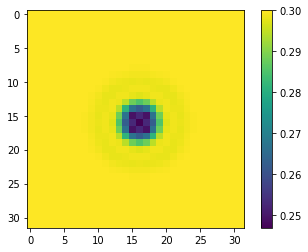

In [13]:
fig, ax = plt.subplots()
im = ax.imshow(np.fft.fftshift(x4.reshape(N, N)))
fig.colorbar(im, ax=ax)
plt.show()

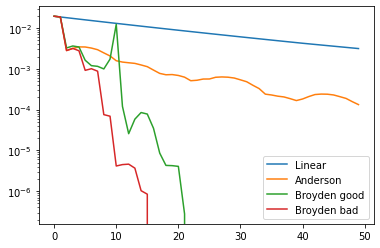

In [14]:
fig, ax = plt.subplots()
ax.semilogy(F1, label='Linear')
ax.semilogy(F2, label='Anderson')
ax.semilogy(F3, label='Broyden good')
ax.semilogy(F4, label='Broyden bad')
ax.legend()
plt.show()

In [15]:
from progress import pindex

In [16]:
maxiter = 30
mix = np.linspace(0, 1, 21)[1:]
resid = np.empty((4, mix.size, maxiter))
kwargs = dict(func=func, x0=x0, args=(params, V), maxiter=maxiter, disp=False)
for i in pindex(mix.size):
    _, resid[0,i] = linear(mix=mix[i], **kwargs)
    _, resid[1,i] = anderson(mix=mix[i], **kwargs)
    _, resid[2,i] = broyden_good(mix=mix[i], **kwargs)
    _, resid[3,i] = broyden_bad(mix=mix[i], **kwargs)

IntProgress(value=0, max=20)

HTML(value='\n            <table>\n                <tr>\n                    <th>Progress:</th>\n             …

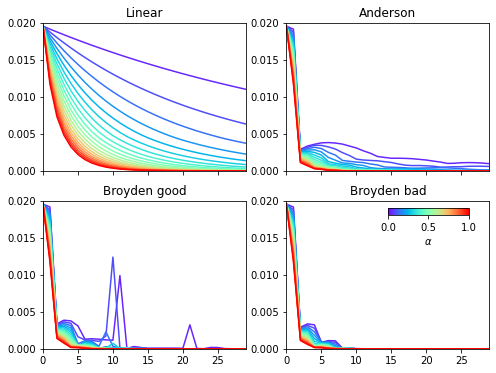

In [17]:
sm = plt.cm.ScalarMappable(plt.Normalize(0, 1), cmap='rainbow')
cs = sm.to_rgba(mix)
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(8, 6))
for i in range(mix.size):
    ax[0,0].plot(resid[0,i], c=cs[i])
    ax[0,1].plot(resid[1,i], c=cs[i])
    ax[1,0].plot(resid[2,i], c=cs[i])
    ax[1,1].plot(resid[3,i], c=cs[i])
for axis in ax.flat:
    axis.set_xlim(0, maxiter-1)
    axis.set_ylim(0, 0.02)
ax[0,0].set_title('Linear')
ax[0,1].set_title('Anderson')
ax[1,0].set_title('Broyden good')
ax[1,1].set_title('Broyden bad')
cax = ax[1,1].inset_axes((0.5, 0.9, 0.4, 0.05))
fig.colorbar(sm, cax=cax, orientation='horizontal', label=r'$\alpha$')
plt.show()

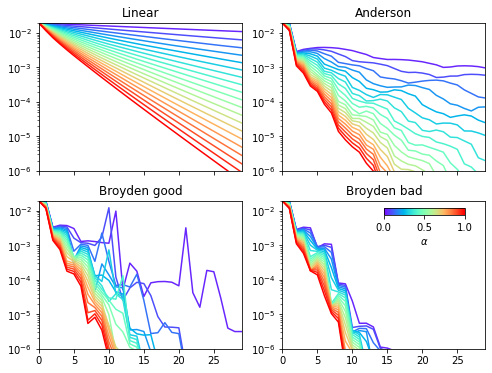

In [18]:
sm = plt.cm.ScalarMappable(plt.Normalize(0, 1), cmap='rainbow')
cs = sm.to_rgba(mix)
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(8, 6))
for i in range(mix.size):
    ax[0,0].semilogy(resid[0,i], c=cs[i])
    ax[0,1].semilogy(resid[1,i], c=cs[i])
    ax[1,0].semilogy(resid[2,i], c=cs[i])
    ax[1,1].semilogy(resid[3,i], c=cs[i])
for axis in ax.flat:
    axis.set_xlim(0, maxiter-1)
    axis.set_ylim(1e-6, 0.02)
ax[0,0].set_title('Linear')
ax[0,1].set_title('Anderson')
ax[1,0].set_title('Broyden good')
ax[1,1].set_title('Broyden bad')
cax = ax[1,1].inset_axes((0.5, 0.9, 0.4, 0.05))
fig.colorbar(sm, cax=cax, orientation='horizontal', label=r'$\alpha$')
plt.show()